In [63]:
import torch
from torch import nn

import sys
import os
path = os.path.abspath("Helpers")
sys.path.append(path)
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm 

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
train_data = datasets.MNIST(
    root = "data", 
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = "data", 
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

In [111]:
train_dataloader = DataLoader(dataset = train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE, 
                             shuffle = False)


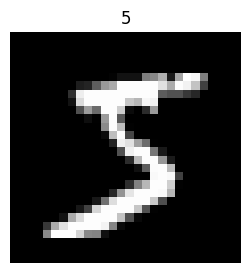

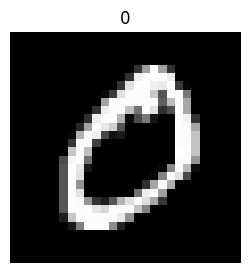

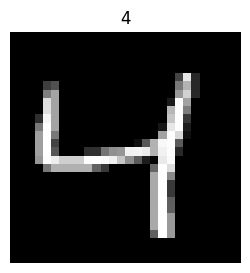

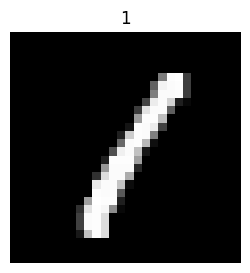

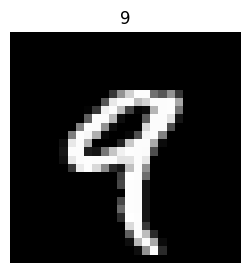

In [112]:
for i in range(5):
    plt.figure(figsize=(3, 3))
    plt.title(int(train_data.targets[i]))
    plt.imshow(train_data.data[i], cmap="gray")
    plt.axis(False)

In [113]:
class ExerciseModelV0(nn.Module):
    def __init__(self, inputShape, hiddenUnits, outputShape):
        super().__init__()
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(in_channels = inputShape, out_channels = hiddenUnits, kernel_size = 2, padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hiddenUnits, out_channels = hiddenUnits, kernel_size = 2, padding = 1, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(in_channels = hiddenUnits, out_channels = hiddenUnits, kernel_size = 2, padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hiddenUnits, out_channels = outputShape, kernel_size = 2, padding = 1, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 640, out_features = outputShape)
        )

    def forward(self, x):
        x = self.convLayer1(x)
        # print(f"Shape after Layer 1 = {x.shape}")
        x = self.convLayer2(x)
        # print(f"Shape after Layer 2 = {x.shape}")
        x = self.classifier(x)
        return x

In [121]:
def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        # Calculate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss # Acccumulate train loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        # Optimizer zero grad
        optimizer.zero_grad()
        # Back propagation
        loss.backward()
        # Optimizer step
        optimizer.step()
    # Divide total train loss by length of train dataloader
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f}")

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1)) 
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def train_loop(epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, device):
    for epoch in tqdm(range(epochs)):
        print(f"\nEpoch: {epoch}\n")
        train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
        test_step(model, test_dataloader, loss_fn, accuracy_fn, device)

def eval_model(model, data_loader, loss_fn, accuracy_fn, device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make Predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        # Scale the loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

        return {
            "model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc
        }
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)
    

In [115]:
loss_fn = nn.CrossEntropyLoss()

In [131]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

model_0 = ExerciseModelV0(inputShape=1, hiddenUnits=10, outputShape = 10).to(device)

In [117]:
print(model_0)

ExerciseModelV0(
  (convLayer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)


In [150]:
train_loop(epochs = 5, 
           model = model_0,  
           train_dataloader = train_dataloader, 
           test_dataloader = test_dataloader, 
           optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1), 
           loss_fn = loss_fn, 
           accuracy_fn = accuracy_fn, 
           device = device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0



  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [151]:
eval_model(
    model = model_0, 
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn= accuracy_fn,
    device = device
)

{'model_name': 'ExerciseModelV0',
 'model_loss': 0.05430574715137482,
 'model_acc': 98.22284345047923}

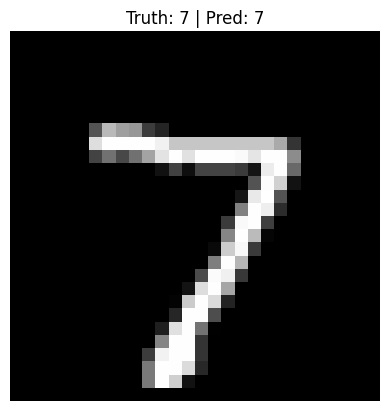

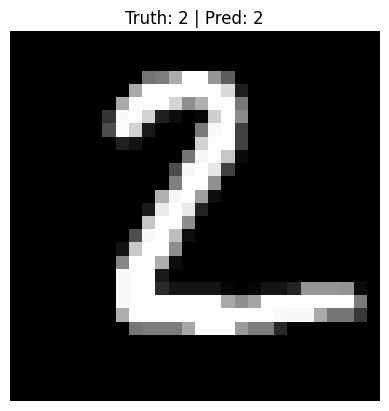

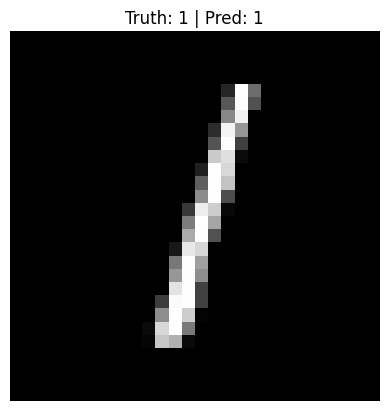

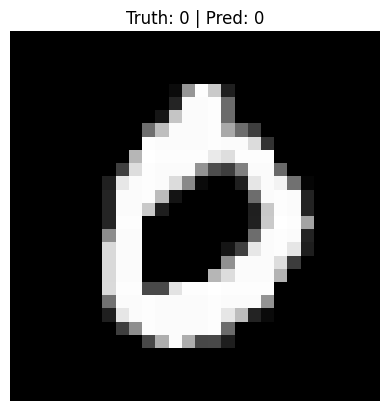

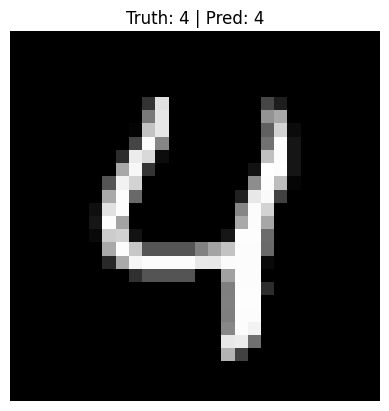

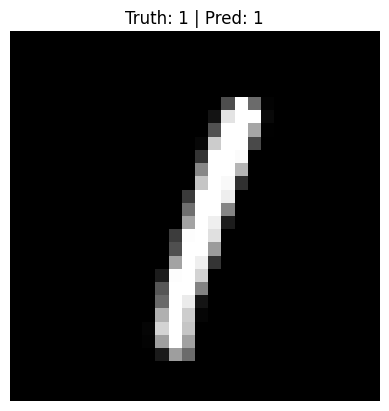

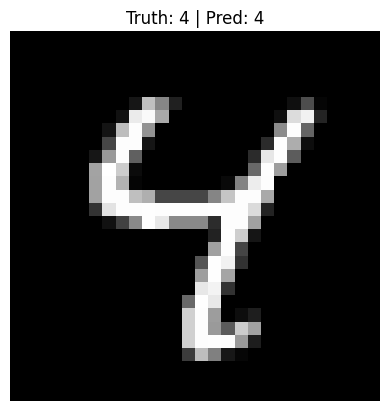

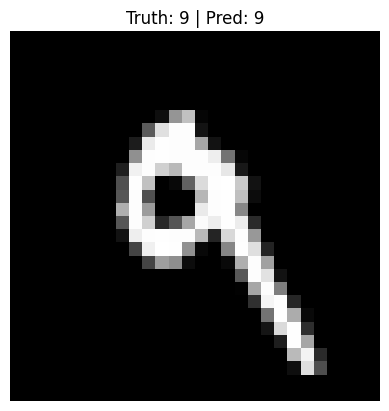

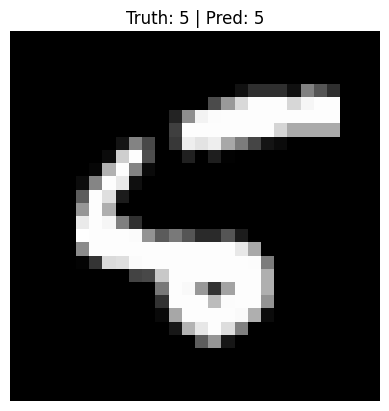

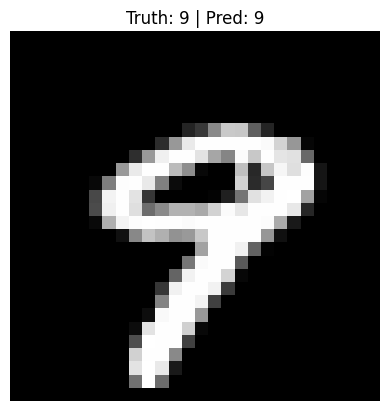

In [153]:
test_images = []
test_labels = []
track = 0
for i in range(10):
    img, label = test_data[i]
    pred_logits = model_0(img.unsqueeze(dim = 0).to(device))
    pred_probs = torch.softmax(pred_logits, dim = 1)
    pred = torch.argmax(pred_probs, dim = 1)
    plt.figure()
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Truth: {label} | Pred: {pred.item()}") 
    plt.axis(False)